In [44]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm

In [45]:
cam0=np.array([[5299.313, 0 ,1263.818] ,
               [0, 5299.313 ,977.763],
                [ 0, 0, 1]])
cam1=np.array([[5299.313, 0, 1438.004],
      [ 0, 5299.313, 977.763],
      [ 0, 0, 1]])
baseline=177.288

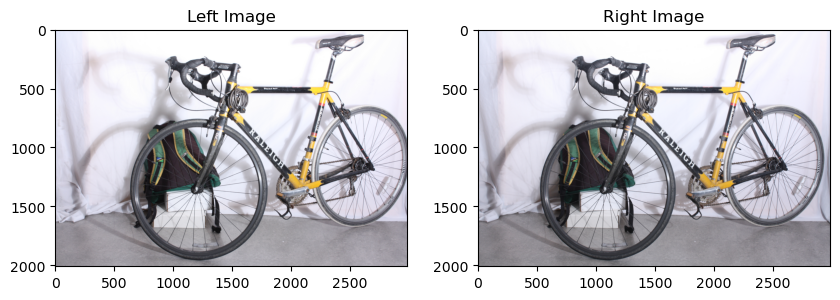

In [46]:
imgl = plt.imread(r'Assignment 1 Input Images\Question 2 and 3 Images\bikeL.png')
imgr = plt.imread(r'Assignment 1 Input Images\Question 2 and 3 Images\bikeR.png')

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgl)
plt.title('Left Image')
plt.subplot(1,2,2)
plt.imshow(imgr)
plt.title('Right Image')
plt.show()


In [47]:
# window_size = 5
# def normalized_cross_corr(img, template):
#     img = img.astype(np.float32)
#     template = template.astype(np.float32)
#     template_mean = cv2.mean(template)[0]
#     template = template - template_mean
#     template_norm = np.linalg.norm(template)
#     img_mean = cv2.blur(img, (window_size, window_size))
#     img = img - img_mean
#     img_norm = np.sqrt(cv2.blur(img**2, (window_size, window_size)))
#     img_norm[img_norm == 0] = 1
#     return cv2.filter2D(img, -1, template[::-1, ::-1]) / (template_norm * img_norm)

In [204]:
def normalized_cross_corr(a, b):
    norm_a = np.linalg.norm(a)
    a = a / norm_a
    norm_b = np.linalg.norm(b)
    b = b / norm_b
    return np.correlate(a.ravel(), b.ravel())

def scan_line_correspondence(img_strip,template):
    max_idx = 0
    max_corr = 0
    stride = template.shape[1]
    pad = stride//2
    # width = img_strip.shape[1]
    # pad_image = np.pad(img_strip, ((0, 0), (stride, stride)), 'constant')
    # slice_ = lambda x: slice(x-pad,x+pad+1)
    for ypixel in range(img_strip.shape[1]-stride+1):
        # slice_y = slice_(ypixel)
        img_patch = img_strip[:, ypixel:ypixel+stride]
        corr = normalized_cross_corr(img_patch, template)
        if corr > max_corr:
            max_idx = ypixel
            max_corr = corr
            if max_corr > 0.98:
                break
    return max_idx
            
def stero_matching(imgl, imgr, template_size):
    height, width = imgl.shape
    disparity = np.zeros_like(imgl)
    for i in tqdm(range(0,height-template_size[0])):
        slice_x = slice(i,i+template_size[0])
        for j in range(0,width-template_size[1]):
            template = imgl[slice_x, j:j+template_size[1]]
            img_strip = imgr[slice_x, :]
            disparity[i,j] = j - scan_line_correspondence(img_strip, template)
    disparity[disparity ==0] = 1
    return disparity

def stero_matching2(imgl, imgr, template_size):
    height, width = imgl.shape
    disparity = np.zeros_like(imgl)
    for i in tqdm(range(0,height,template_size[0])):
        slice_x = slice(i,i+template_size[0])
        jr_prev = 0
        for j in range(0,width,template_size[1]):
            template = imgl[slice_x, j:j+template_size[1]]
            img_strip = imgr[slice_x, jr_prev:]
            jr = scan_line_correspondence(img_strip, template)
            disparity[slice_x, j:j+template_size[1]] = j - jr
            jr_prev = jr   
    disparity[disparity ==0] = disparity[disparity != 0].mean()
    return disparity

In [205]:
l_dir = r'Assignment 1 Input Images\Question 2 and 3 Images\bikeL.png'
r_dir = r'Assignment 1 Input Images\Question 2 and 3 Images\bikeR.png'
def read_img(img_dir):
    img = cv.imread(img_dir)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    return gray

In [206]:
img_l = read_img(l_dir)
img_r = read_img(r_dir)
disparity = stero_matching2(img_l, img_r, (7,7))

100%|██████████| 287/287 [01:37<00:00,  2.94it/s]


In [207]:
disparity

array([[1447.3306, 1447.3306, 1447.3306, ..., 2982.    , 2982.    ,
        2982.    ],
       [1447.3306, 1447.3306, 1447.3306, ..., 2982.    , 2982.    ,
        2982.    ],
       [1447.3306, 1447.3306, 1447.3306, ..., 2982.    , 2982.    ,
        2982.    ],
       ...,
       [1447.3306, 1447.3306, 1447.3306, ..., 2982.    , 2982.    ,
        2982.    ],
       [1447.3306, 1447.3306, 1447.3306, ..., 2982.    , 2982.    ,
        2982.    ],
       [1447.3306, 1447.3306, 1447.3306, ..., 2982.    , 2982.    ,
        2982.    ]], dtype=float32)

In [208]:
z = baseline * cam0[0,0] / (disparity  + cam1[0,2] - cam0[0,2])

In [209]:
cam0[0,2]

1263.818

In [210]:
# np.unique(z[0])
z[0].min(), z[0].max()

(297.67087, 5185.3037)

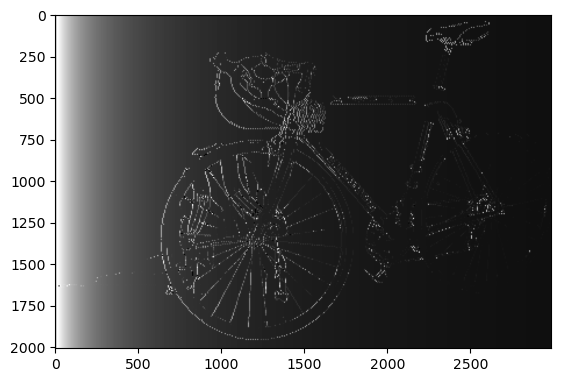

In [217]:
plt.imshow(np.clip(z,0,5000),cmap='gray')